# Model 2 - RNN using both geo-spatial and kinematic features

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sys.path.append('../dtu-deep-learning-project/src/')
from data_utils import *
clear_output(wait=False)

### Load train, validation and test data

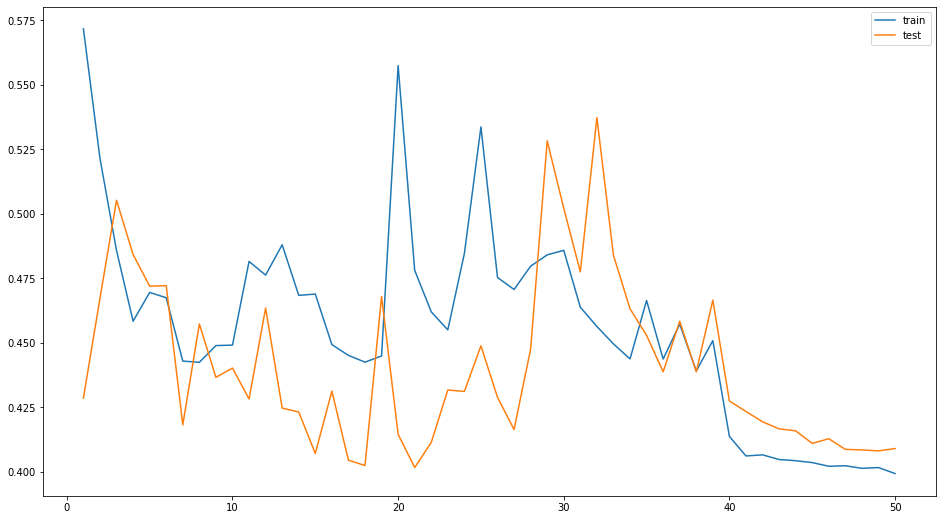

average epoch duration 6.007422456741333
stdev epoch duration 0.36555904952806645
Training lasted 300.37112283706665
test
4


In [2]:
classification_test_performance = []
for k in range(1,5):
    if k == 1:
        user_train, user_val, user_test = train, val, test = train_test_data_split()
        user_train = user_train+user_val
        train=train+val
    else:
        rotate = user_test
        user_test = test = user_train[0:len(rotate)]
        train = train+rotate
        user_train = train[len(rotate)-12:]
        train = user_train
    ###########
    seq_cutoff_speed = 45
    seq_cutoff_time = 60
    filter_seq = 5
    ###########
    data_train = pd.concat([create_data_frame(*load_user_data(user,load_web_mercator = True), segmentation=True, seq_cutoff_time = seq_cutoff_time, seq_cutoff_speed = seq_cutoff_speed) for user in user_train]).reset_index(drop=True)
    data_test = pd.concat([create_data_frame(*load_user_data(user,load_web_mercator = True), segmentation=True, seq_cutoff_time = seq_cutoff_time, seq_cutoff_speed = seq_cutoff_speed) for user in user_test]).reset_index(drop=True)
    ###########
    class TensorDataset(torch.utils.data.Dataset):

        def __init__(self, df, filter_seq=filter_seq):
            self.seq = np.stack([np.roll(df[['delta_d', 'bearing']].values, i, axis = 0) for i in range(filter_seq, -1, -1)], axis = 1)
            self.seq = self.seq[df['segment_ix'] >= filter_seq]

            self.labels = df[df['segment_ix'] >= filter_seq]['label'].values        
            self.user_id = df[df['segment_ix'] >= filter_seq]['user'].values
            tod = df[df['segment_ix'] >= filter_seq]['tod'].values
            self.tod_one_hot = np.eye(5)[tod]

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, key):
            return self.seq[key], self.tod_one_hot[key], self.labels[key]   
    ############
    # Network Parameters
    IMG_INPUT_H_W = 9, 9
    IMG_INPUT_C = 11
    TOD_INPUT_DIM = 6

    SEQ_LENGTH = filter_seq+1
    SEQ_FEATURES = 2
    TOD_INPUT_DIM = 5
    RNN_HIDDEN_DIM = 4
    RNN_NUM_LAYERS = 2
    RNN_BIDIRECT = True
    FC_HIDDEN_DIM = 512
    DROPOUT_PROP = 0.45

    NUM_CLASSES = 2

    # Training Parameters
    NUM_EPOCH = 50
    BATCH_SIZE = 12000
    LEARNING_RATE = 0.1
    LEARNING_DECAY_FACTOR = 0.1
    LEARNING_DECAY_EPOCHS = [40]
    #############
    train_dataloader = torch.utils.data.DataLoader(TensorDataset(data_train), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
    test_dataloader = torch.utils.data.DataLoader(TensorDataset(data_test), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
    #############
    def adjust_lr(optimizer, epoch):
        number_decay_points_passed = np.sum(epoch >= np.array(LEARNING_DECAY_EPOCHS))
        lr = LEARNING_RATE * (LEARNING_DECAY_FACTOR ** number_decay_points_passed)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        return lr

    class SelectItem(nn.Module):
        def __init__(self, item_index):
            super(SelectItem, self).__init__()
            self._name = 'selectitem'
            self.item_index = item_index

        def forward(self, inputs):
            return inputs[self.item_index]
    #############
    class CnnNet(nn.Module):

        def __init__(self):
            super(CnnNet, self).__init__()

            rnn_output_dim = SEQ_LENGTH*RNN_HIDDEN_DIM
            if RNN_BIDIRECT:
                rnn_output_dim *= 2

            self.rnn_layer = nn.Sequential(
                nn.GRU(SEQ_FEATURES, RNN_HIDDEN_DIM, RNN_NUM_LAYERS, batch_first=True, bidirectional=RNN_BIDIRECT),
                SelectItem(0),
                nn.Flatten(start_dim=1),
                nn.BatchNorm1d(rnn_output_dim),
                nn.ReLU(),
                nn.Dropout(DROPOUT_PROP)
            )
            self.fc_layer = nn.Sequential(
                nn.Linear(TOD_INPUT_DIM + rnn_output_dim, FC_HIDDEN_DIM),
                nn.BatchNorm1d(FC_HIDDEN_DIM),
                nn.ReLU(),
                nn.Dropout(DROPOUT_PROP),
                nn.Linear(FC_HIDDEN_DIM, FC_HIDDEN_DIM//5),
                nn.BatchNorm1d(FC_HIDDEN_DIM//5),
                nn.ReLU(),
                nn.Dropout(DROPOUT_PROP),
                nn.Linear(FC_HIDDEN_DIM//5, NUM_CLASSES),
                #nn.BatchNorm1d(NUM_CLASSES),
                #nn.ReLU(),
                #nn.Dropout(DROPOUT_PROP)
            )
            #print(CNN_HIDDEN_DIM_2 * h * w + TOD_INPUT_DIM + rnn_output_dim)      

        def forward(self, X_seq, X_tod):
            out_seq = self.rnn_layer(X_seq)
            #print(f'5     {X_seq.shape}')
            out = torch.cat([out_seq, X_tod], dim=1)
            #print(f'6     {out.shape}')
            out = self.fc_layer(out)

            return out

    ##################
    class_weights = [(data_train['label'] == 0).sum()/(data_train['label'] == x).sum() for x in range(NUM_CLASSES)]
    ##################
    device = torch.device('cuda:1') # PyTorch v0.4.0
    model = CnnNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
    criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).to(device))
    ##################
    ##################
    phases = {
        'train': {
            'dataloader': train_dataloader,
            'is_training': True,
        },
        'test': {
            'dataloader': test_dataloader,
            'is_training': False,
        }
    }
    ###################
    epochComputationTime =  []
    for epoch in range(1, NUM_EPOCH + 1):

        for phase_name, phase in phases.items():
            epoach_loss = 0.0

            phase_is_training = phase['is_training']
            phase_dataloader = phase['dataloader']
            model.train(phase_is_training)

            # Ajust and save the learning rate in the phase dict
            if phase_is_training:
                startEpoch = time.time()
                lr = adjust_lr(optimizer, epoch)
                phase.setdefault('lr', []).append(lr)

            # Iterate over each bath in the phase
            for i, batch in enumerate(phase_dataloader, 1):
                #print(i)
                #print(batch[0].shape)
                X_seq, X_tod, y = batch


                X_seq = X_seq.to(device, dtype=torch.float)
                X_tod = X_tod.to(device, dtype=torch.float)
                y = y.to(device, dtype=torch.int64)

                with torch.set_grad_enabled(phase_is_training):
                    out = model(X_seq, X_tod)
                    loss = criterion(out, y)

                if phase_is_training:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_value_(model.parameters(), 0.5)
                    optimizer.step()


                epoach_loss += loss.item()

            # Save the loss for the epoch in the phase dict
            phase.setdefault('loss', []).append(epoach_loss/i)
            if phase_is_training:
                endEpoch = time.time()
                epochComputationTime.append(endEpoch-startEpoch)
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize = (16, 9))
        #ax.set_yscale('log')

        for phase_name, phase in phases.items():
            ax.plot(np.arange(1, epoch + 1), phase['loss'], label = phase_name)        

        ax.legend()
        plt.show();            
        print(f'average epoch duration {np.mean(epochComputationTime)}')
        print(f'stdev epoch duration {np.std(epochComputationTime)}')
        print(f'Training lasted {np.sum(epochComputationTime)}')
    ###########################
    for phase_name, phase in phases.items():
        if phase['is_training']: 
            continue

        phase_dataloader = phase['dataloader']
        phase['predicted'] = []
        phase['true'] = []

        for i, batch in enumerate(phase_dataloader, 1):
            X_seq, X_tod, y = batch

            phase['true'].extend(list(y.numpy()))

            X_seq = X_seq.to(device, dtype=torch.float)
            X_tod = X_tod.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)

            with torch.no_grad():
                out = model(X_seq, X_tod)
                probability, predicted = torch.max(out, 1)

            phase['predicted'].extend(list(predicted.cpu().numpy()))
    for phase_name, phase in phases.items():
        if phase['is_training']: 
            continue

        print(phase_name)
        cr=classification_report(phase['true'], phase['predicted'], target_names = ['Motion','Stop'],output_dict=True)
        classification_test_performance.append(cr)
        print(k)
        #print(cr)

In [3]:
F1_macro_AVG = []
for cr in classification_test_performance:
    F1_macro_AVG.append(cr['macro avg']['f1-score'])

In [4]:
print(f'MEAN = {np.mean(F1_macro_AVG)}, STDEV = {np.std(F1_macro_AVG)}')

MEAN = 0.7324861563257652, STDEV = 0.1828402375981723


In [5]:
F1_macro_AVG

Loading BokehJS ...

[0.8131823365451702,
 0.8697031623273928,
 0.41781282673366144,
 0.8292462996968364]